In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [94]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [95]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z'
big_training_dir = '/u/ki/swmclau2/des/PearceFHC_wp_z'
#training_dirs = ['/u/ki/swmclau2/des/PearceLHC_wp_rp','/u/ki/swmclau2/des/PearceLHC_wp_rp_dense',
#                 '/u/ki/swmclau2/des/PearceFHC_wp_rp/']

truth_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_test'

In [96]:
gbdt_hyperparams = {'n_estimators': int(1e3),
              'max_depth': 5}
gp_hyperparams = {}

In [97]:
fixed_params= {'z':0.0}

In [98]:
emu1 = OriginalRecipe(training_dir,method = 'gbdt',hyperparams=gbdt_hyperparams, fixed_params=fixed_params)
#emu1 = OriginalRecipe(training_dir,method = 'gp', params=or_params)

In [99]:
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [100]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [101]:
low, high = emu1.get_param_bounds(y_param)       
y_vals = np.linspace(low, high, 4)
em_params[y_param] = y_vals

In [102]:
print em_params[y_param]

[ 11.7         11.96666667  12.23333333  12.5       ]


In [103]:
moe_kwargs = {'experts': 10, 'overlap': 1}

In [104]:
GOF_dict2 = {}
#for method, hp, td in zip(['gp', 'gbdt', 'gbdt', 'svr'],\
#                          [gp_hyperparams, gbdt_hyperparams, gbdt_hyperparams, {}],\
#                          [training_dir, training_dir, training_dirs, training_dir]):
#for method, hp, td in zip(['GP','MOE'],\
#                          [gp_hyperparams, gp_hyperparams],\
#                          [training_dir, big_training_dir]):
for method, hp, td in zip(['GP'],\
                          [gp_hyperparams],\
                          [training_dir]):
    print method
    if method == 'GP':
        emu = OriginalRecipe(td, method='gp', hyperparams=hp,fixed_params = fixed_params)
    elif method == 'MOE':
        emu = ExtraCrispy(td,experts = moe_kwargs['experts'], overlap = moe_kwargs['overlap'], method = 'gp',\
                          hyperparams=hp, fixed_params = fixed_params )
    print 'Done Building'
        
    GOF = emu.goodness_of_fit(truth_dir)
    print 'GOF'
    frac_err = emu.goodness_of_fit(truth_dir, statistic='frac')
    print 'frac'
    abs_err = emu.goodness_of_fit(truth_dir, statistic='abs')
    print 'abs'
    if method not in GOF_dict2:
        GOF_dict2[method] = (GOF, frac_err, abs_err)
    else:
        GOF_dict2[method+' more training'] = (GOF, frac_err, abs_err)

GP
Done Building
GOF
frac
abs


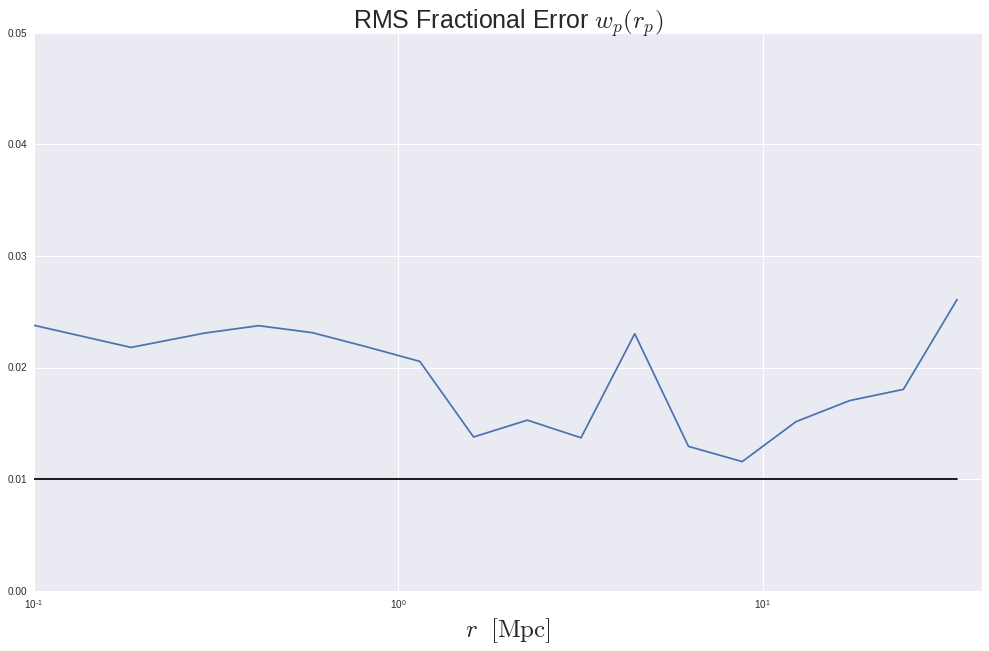

In [112]:
fig = plt.figure(figsize= (17,10))

for c, (method, (GOF, frac_errs, abs_errs) ) in zip(colors, GOF_dict2.iteritems()):
    #frac_mean = np.abs(frac_errs).mean(axis=0)
    #frac_std = np.abs(frac_errs).std(axis=0)
    frac_mean = np.sqrt(np.mean(frac_errs**2, axis = 0))
    
    #print frac_mean
    #print
    plt.plot(emu.scale_bin_centers, frac_mean, color = c)
    #plt.plot(emu.scale_bin_centers, frac_mean+frac_std, ls=':', lw =3, color = c)
    #plt.plot(emu.scale_bin_centers, frac_mean-frac_std, ls=':', lw =3, color = c)

    #plt.plot(emu.bin_centers, frac_mean-frac_std, ls=':', lw =3, color = c)
    #plt.fill_between(emu.scale_bin_centers, frac_mean-frac_std, frac_mean+frac_std, color = c, alpha = 0.3)
    
plt.plot(emu.scale_bin_centers, np.ones(len(emu.scale_bin_centers))*0.01, color = 'k')
plt.title(r'RMS Fractional Error $w_p(r_p)$', fontsize = 25)
plt.xlim(xmin = 0.1, xmax = 40)
plt.ylim(ymin = 0, ymax =0.05)
#plt.loglog()
plt.xscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.legend(loc='best', fontsize = 15)

#plt.ylabel(r'Relative Error', fontsize = 25)

plt.show()

In [106]:
import cPickle as pickle
with open('GOF_dict2.pkl', 'w') as f:
    pickle.dump(GOF_dict2, f)